## Unet with VGG-16 encoder

A U-Net architecture utilizing a pre-trained VGG16 model as its encoder. The input layer accepts images of a specified shape, and the VGG16 model, pre-loaded with ImageNet weights, extracts features at various depths. Key feature maps from VGG16's convolutional layers serve as skip connections, facilitating information transfer between the encoder and decoder. The decoder comprises a series of blocks that upsample the feature maps, concatenate them with corresponding skip connections, and apply convolutions, progressively reconstructing the image.

##Importing libraries

In [2]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
#from tensorflow.keras.applications import VGG16

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam


import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn.model_selection import train_test_split
from utils import jacard_coef, dice_coef, dice_loss, focal_loss, combined_loss, jacard_coef_loss
from models import AttentionUNet, VGG16UNet
from keras.callbacks import EarlyStopping


c:\Users\hniu\Anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Dataset Preparation

In [3]:
# # Load the images and masks using numpy
src_images = np.load('dataset/train_images.npy')
tar_images = np.load('dataset/train_masks.npy')
src_test_images = np.load('dataset/test_images.npy')
tar_test_images = np.load('dataset/test_masks.npy')

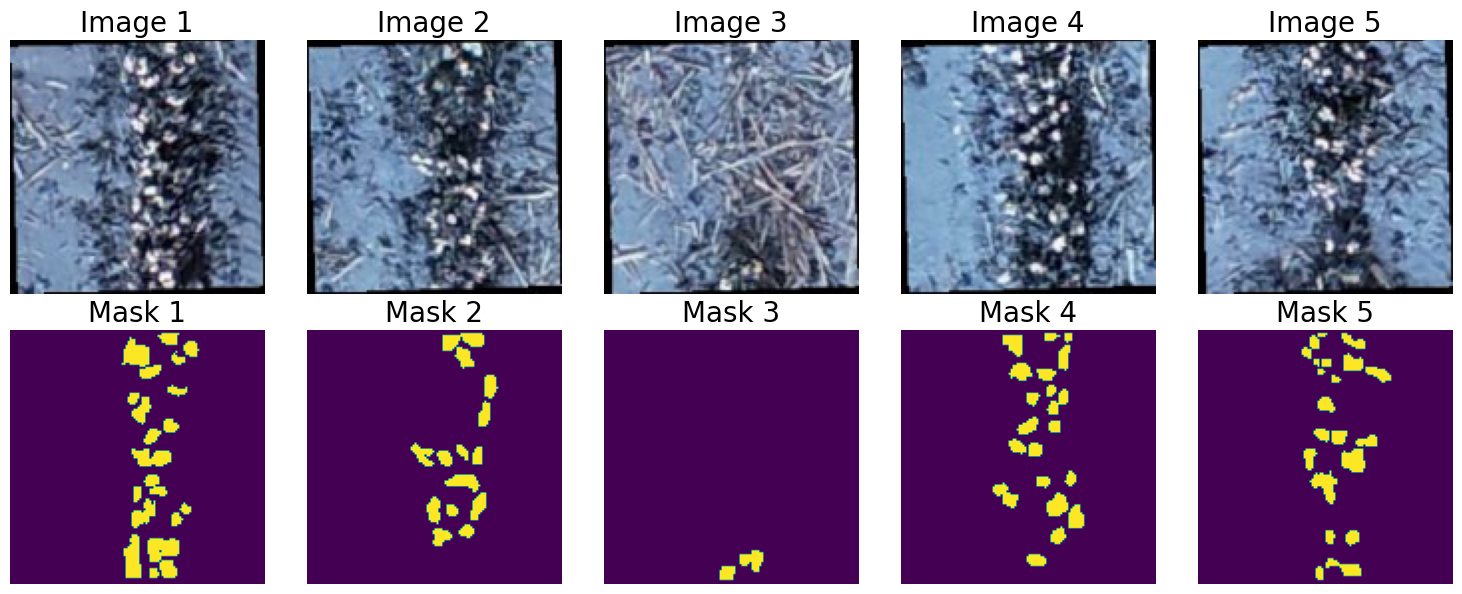

In [17]:
# Set up the figure
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot the images in the first row
for i in range(5):
    axes[0, i].imshow(src_images[i]) # , cmap='gray'
    axes[0, i].axis('off')  # Hide axis
    axes[0, i].set_title(f"Image {i+1}", fontsize=20)

# Plot the related masks in the second row
for i in range(5):
    axes[1, i].imshow(tar_images[i]) # , cmap='gray'
    axes[1, i].axis('off')  # Hide axis
    axes[1, i].set_title(f"Mask {i+1}", fontsize=20)

plt.tight_layout()

# Save the figure as a PNG file with 300 DPI
image_folder = './plot_images'
plt.savefig(os.path.join(image_folder, 'image_grid.png'), dpi=300, format='png')

plt.show()

##Model

In [3]:
input_shape = (128,128,3)
vgg16_unet = VGG16UNet(input_shape)
model = vgg16_unet.get_model()

learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=dice_loss, metrics=[jacard_coef])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(src_images,tar_images,validation_split = 0.1,batch_size = 5,epochs = 30, callbacks=[early_stopping])

In [13]:
# plt.plot(history.history['jacard_coef'])
# plt.plot(history.history['val_jacard_coef'])
# plt.title('Custom Metric')
# plt.ylabel('Jacard Coef')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

## Inference

In [17]:
pred = model.predict(src_test_images)
print(dice_coef(tar_test_images,pred))
print(jacard_coef(tar_test_images,pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 746ms/step
tf.Tensor(0.7707659, shape=(), dtype=float32)
tf.Tensor(0.62702936, shape=(), dtype=float32)


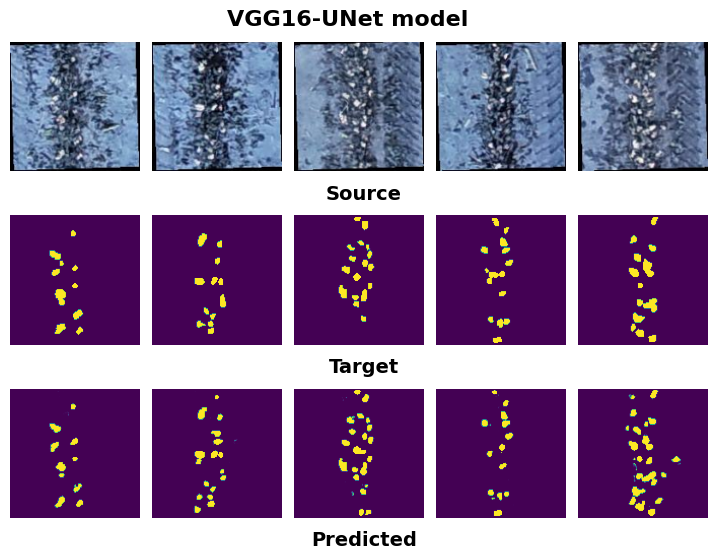

In [19]:
n_samples = 5
# Assuming 'expected' contains your ground truth images and 'pred' contains predicted images
plt.figure(figsize=(9, 6))

for i in range(n_samples):
    # Plot actual image
    plt.subplot(3, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(src_test_images[i])

    # Plot expected image
    plt.subplot(3, n_samples, 1 +  n_samples + i)
    plt.axis('off')
    plt.imshow(tar_test_images[i])

    # Plot predicted image
    plt.subplot(3, n_samples, 1 + 2 * n_samples + i)
    plt.axis('off')
    plt.imshow(pred[i])


plt.subplot(3, n_samples, 1)
plt.text(350, 150, 'Source', va='center', ha='center', rotation=0, fontsize=14, weight='bold')

plt.subplot(3, n_samples, 1 + n_samples)
plt.text(350, 150, 'Target', va='center', ha='center', rotation=0, fontsize=14, weight='bold')

plt.subplot(3, n_samples, 1 + 2 * n_samples)
plt.text(350, 150, 'Predicted', va='center', ha='center', rotation=0, fontsize=14, weight='bold')

plt.suptitle('VGG16-UNet model', fontsize=16, weight='bold')
# Adjust layout to fit titles
plt.subplots_adjust(wspace=0.1, hspace=0.1, top=0.95)

plt.show()